In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 3a
commitnumber = 5014a19
conc = 0.0004
dv = 0.001
klin = 6.375563e-24
molecule = co2
ng_adju = [0, 0, 0]
ng_refs = [3, 2, 4]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250), (500, 250)]
tsfc = 294
vmax = 620
vmin = 540
w_diffuse = [(1.6, 1.6, 1.7), (1.75, 1.75), (1.55, 1.55, 1.6, 1.85)]
wgt = [(0.7, 0.3, 0.7), (0.7, 0.6), (0.4, 0.5, 0.8, 0.95)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

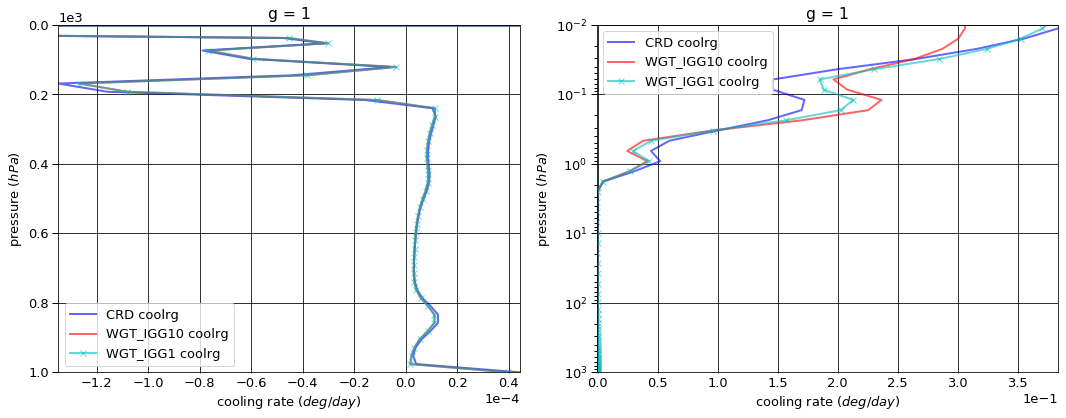

# Figure: cooling rate g-group 2

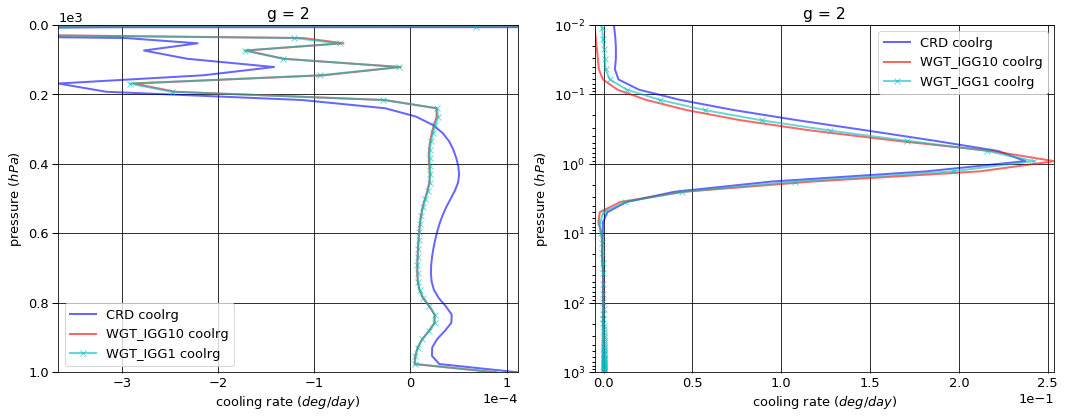

# Figure: cooling rate g-group 3

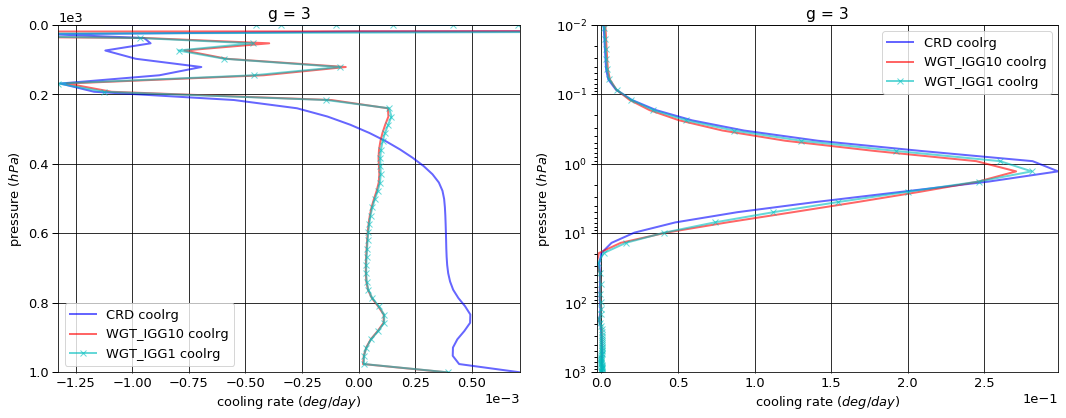

# Figure: cooling rate g-group 4

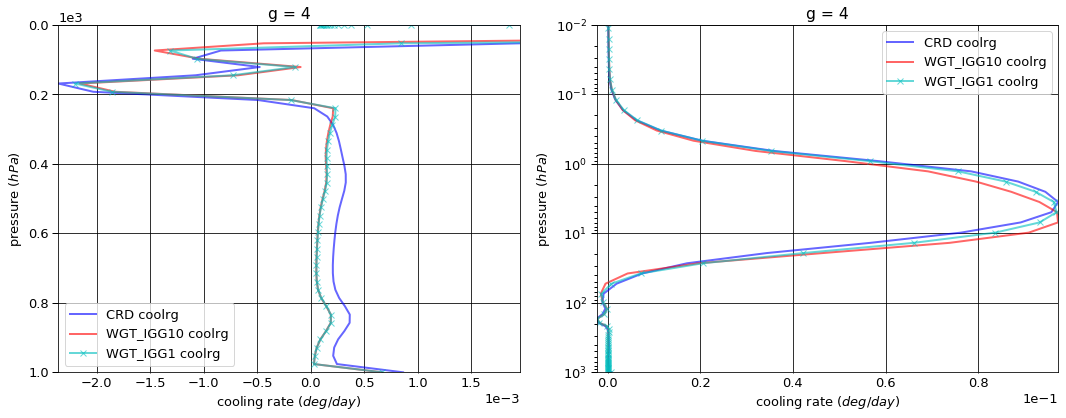

# Figure: cooling rate g-group 5

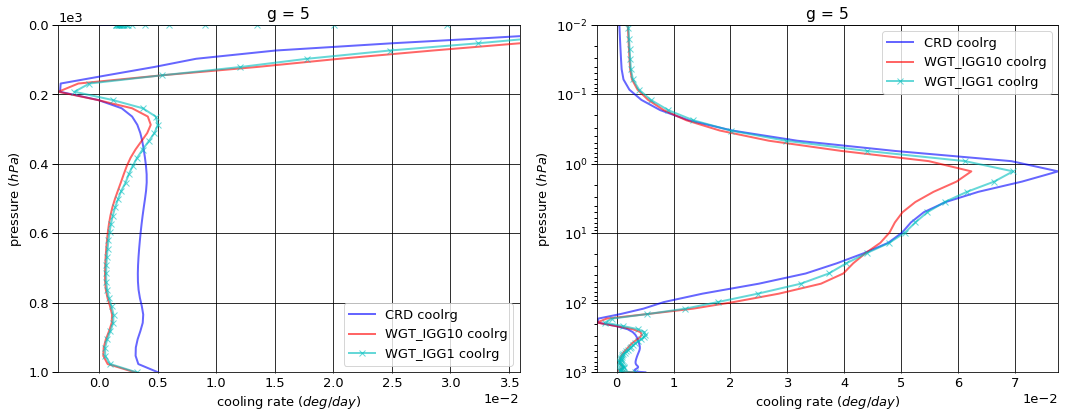

# Figure: cooling rate g-group 6

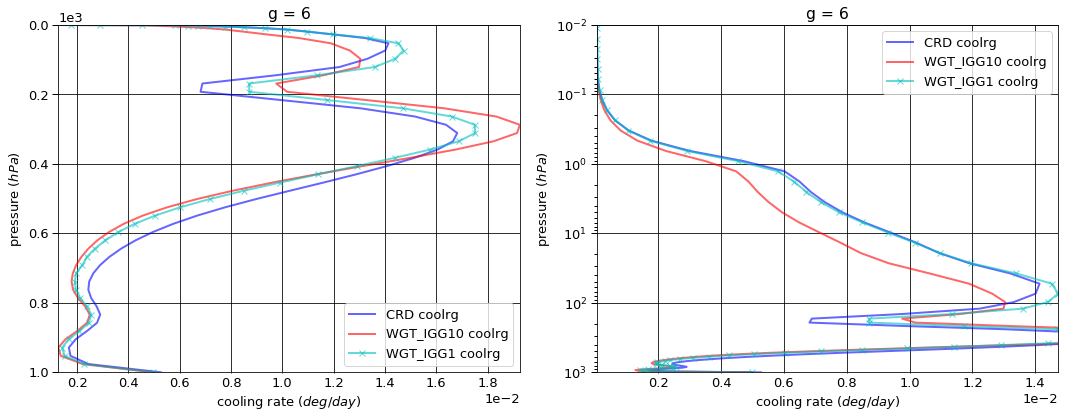

# Figure: cooling rate g-group 7

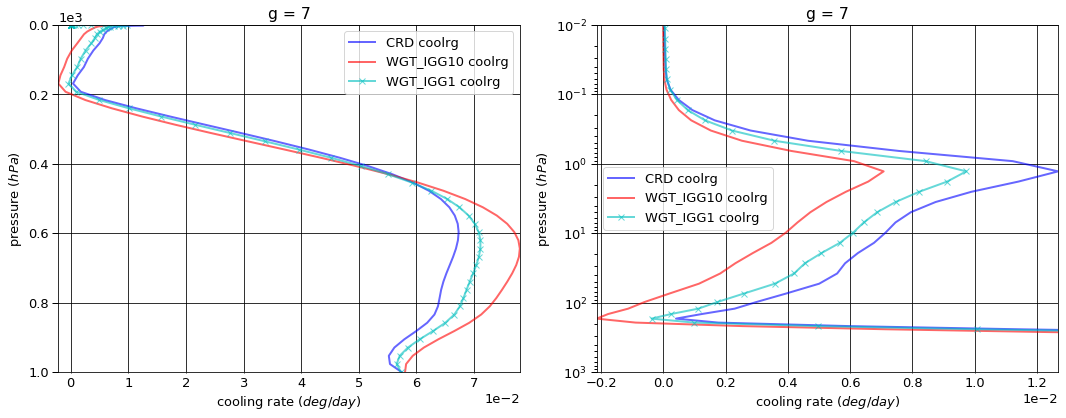

# Figure: cooling rate g-group 8

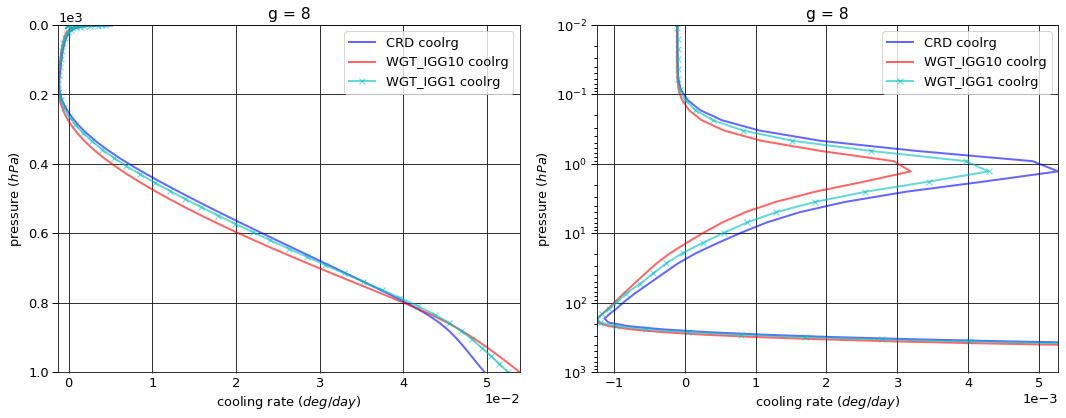

# Figure: cooling rate g-group 9

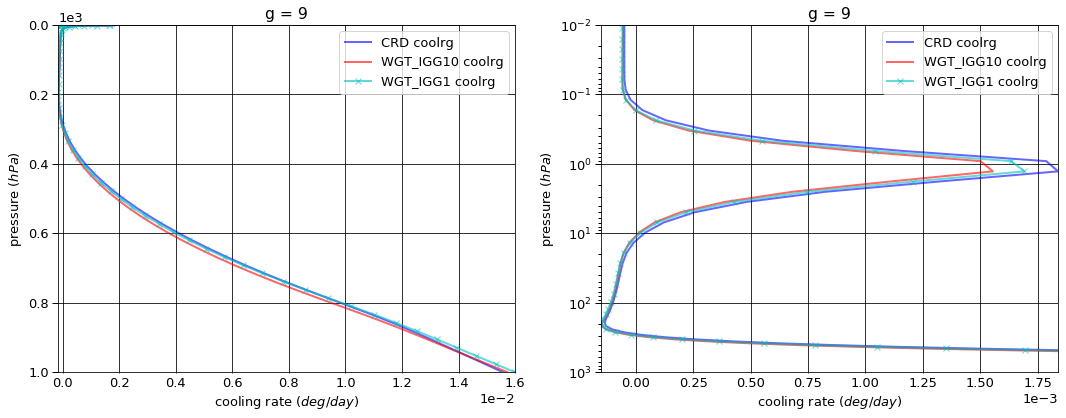

# Figure: cooling rate g-group total

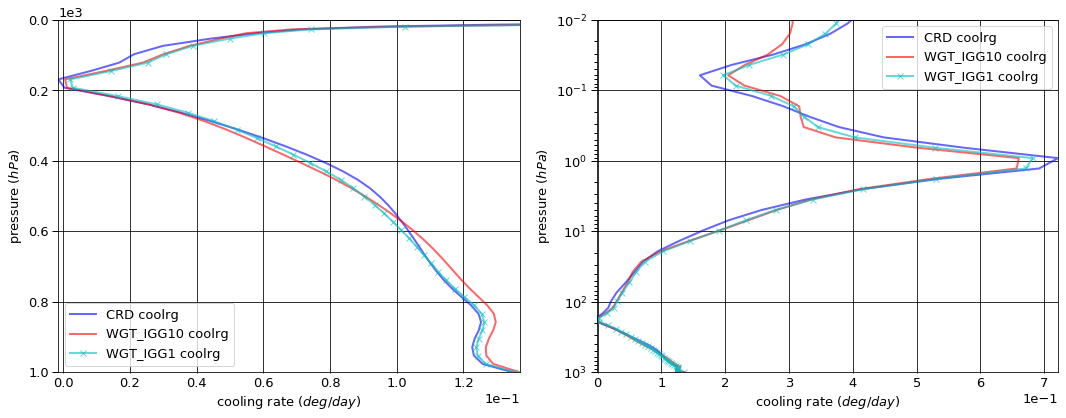

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.011662  0.000000  -0.011662
  1013.0   76     -0.026654  0.026523  -0.000131
2 0.0      1      -0.039952  0.000000  -0.039952
  1013.0   76     -0.059196  0.058725  -0.000471
3 0.0      1      -0.155312  0.000000  -0.155312
  1013.0   76     -0.259090  0.246717  -0.012373
4 0.0      1      -0.208136  0.000000  -0.208136
  1013.0   76     -0.447316  0.442124  -0.005192
5 0.0      1      -0.793914  0.000000  -0.793914
  1013.0   76     -1.712117  1.587862  -0.124255
6 0.0      1      -0.994397  0.000000  -0.994397
  1013.0   76     -2.342321  2.317368  -0.024953
7 0.0      1      -6.513232  0.000000  -6.513232
  1013.0   76     -9.718741  8.429732  -1.289009
8 0.0      1      -7.572272  0.000000  -7.572272
  1013.0   76     -8.268252  2.996895  -5.271358
9 0.0      1     -13.293057  0.000000 -13.293057
  1013.0   76    -13.401723  0.651383 -12.750340


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.011257  0.000000  -0.011257
  1013.0   76     -0.026007  0.025898  -0.000109
2 0.0      1      -0.041321  0.000000  -0.041321
  1013.0   76     -0.057841  0.057596  -0.000245
3 0.0      1      -0.153348  0.000000  -0.153348
  1013.0   76     -0.254049  0.252971  -0.001077
4 0.0      1      -0.210757  0.000000  -0.210757
  1013.0   76     -0.436862  0.435025  -0.001836
5 0.0      1      -0.637879  0.000000  -0.637879
  1013.0   76     -1.681963  1.671620  -0.010343
6 0.0      1      -0.963800  0.000000  -0.963800
  1013.0   76     -2.293256  2.271996  -0.021260
7 0.0      1      -6.518935  0.000000  -6.518935
  1013.0   76     -9.560399  8.573912  -0.986487
8 0.0      1      -7.679379  0.000000  -7.679379
  1013.0   76     -8.292689  2.832415  -5.460275
9 0.0      1     -13.527823  0.000000 -13.527823
  1013.0   76    -13.632342  0.627959 -13.004382


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.011320  0.000000  -0.011320
  1013.0   76     -0.026007  0.025898  -0.000109
2 0.0      1      -0.040709  0.000000  -0.040709
  1013.0   76     -0.057841  0.057594  -0.000247
3 0.0      1      -0.152189  0.000000  -0.152189
  1013.0   76     -0.254049  0.252949  -0.001099
4 0.0      1      -0.209732  0.000000  -0.209732
  1013.0   76     -0.436862  0.435018  -0.001844
5 0.0      1      -0.647719  0.000000  -0.647719
  1013.0   76     -1.681963  1.670154  -0.011809
6 0.0      1      -0.969514  0.000000  -0.969514
  1013.0   76     -2.293256  2.270886  -0.022371
7 0.0      1      -6.446425  0.000000  -6.446425
  1013.0   76     -9.560399  8.461606  -1.098793
8 0.0      1      -7.610206  0.000000  -7.610206
  1013.0   76     -8.292689  2.988293  -5.304396
9 0.0      1     -13.522029  0.000000 -13.522029
  1013.0   76    -13.632342  0.653225 -12.979117


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000405  0.000000  0.000405
  1013.0   76     0.000646 -0.000625  0.000021
2 0.0      1     -0.001369  0.000000 -0.001369
  1013.0   76     0.001355 -0.001128  0.000226
3 0.0      1      0.001964  0.000000  0.001964
  1013.0   76     0.005041  0.006254  0.011296
4 0.0      1     -0.002622  0.000000 -0.002622
  1013.0   76     0.010454 -0.007099  0.003355
5 0.0      1      0.156036  0.000000  0.156036
  1013.0   76     0.030153  0.083759  0.113912
6 0.0      1      0.030597  0.000000  0.030597
  1013.0   76     0.049064 -0.045372  0.003693
7 0.0      1     -0.005702  0.000000 -0.005702
  1013.0   76     0.158342  0.144180  0.302522
8 0.0      1     -0.107107  0.000000 -0.107107
  1013.0   76    -0.024437 -0.164480 -0.188917
9 0.0      1     -0.234766  0.000000 -0.234766
  1013.0   76    -0.230619 -0.023424 -0.254042


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000342  0.000000  0.000342
  1013.0   76     0.000646 -0.000625  0.000021
2 0.0      1     -0.000757  0.000000 -0.000757
  1013.0   76     0.001355 -0.001131  0.000224
3 0.0      1      0.003123  0.000000  0.003123
  1013.0   76     0.005041  0.006232  0.011274
4 0.0      1     -0.001597  0.000000 -0.001597
  1013.0   76     0.010454 -0.007107  0.003348
5 0.0      1      0.146195  0.000000  0.146195
  1013.0   76     0.030153  0.082292  0.112445
6 0.0      1      0.024883  0.000000  0.024883
  1013.0   76     0.049064 -0.046482  0.002582
7 0.0      1      0.066808  0.000000  0.066808
  1013.0   76     0.158342  0.031874  0.190216
8 0.0      1     -0.037935  0.000000 -0.037935
  1013.0   76    -0.024437 -0.008601 -0.033038
9 0.0      1     -0.228972  0.000000 -0.228972
  1013.0   76    -0.230619  0.001841 -0.228777

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.392989
  1001.112500 75     0.000044
2 0.000312    1     -0.002240
  1001.112500 75     0.000112
3 0.000312    1     -0.001119
  1001.112500 75     0.000711
4 0.000312    1      0.000059
  1001.112500 75     0.000862
5 0.000312    1     -0.000040
  1001.112500 75     0.005042
6 0.000312    1      0.000027
  1001.112500 75     0.005270
7 0.000312    1     -0.000023
  1001.112500 75     0.057481
8 0.000312    1     -0.000116
  1001.112500 75     0.049737
9 0.000312    1     -0.000048
  1001.112500 75     0.015577


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1      0.246973
  1001.112500 75     0.000040
2 0.000312    1     -0.009725
  1001.112500 75     0.000088
3 0.000312    1      0.000447
  1001.112500 75     0.000388
4 0.000312    1      0.000097
  1001.112500 75     0.000665
5 0.000312    1      0.001401
  1001.112500 75     0.003067
6 0.000312    1      0.000024
  1001.112500 75     0.004964
7 0.000312    1     -0.000039
  1001.112500 75     0.058022
8 0.000312    1     -0.000108
  1001.112500 75     0.053937
9 0.000312    1     -0.000052
  1001.112500 75     0.015742


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1      0.345330
  1001.112500 75     0.000040
2 0.000312    1     -0.007331
  1001.112500 75     0.000089
3 0.000312    1     -0.000452
  1001.112500 75     0.000392
4 0.000312    1      0.000085
  1001.112500 75     0.000666
5 0.000312    1      0.001440
  1001.112500 75     0.003202
6 0.000312    1      0.000033
  1001.112500 75     0.004970
7 0.000312    1      0.000002
  1001.112500 75     0.057333
8 0.000312    1     -0.000109
  1001.112500 75     0.052565
9 0.000312    1     -0.000054
  1001.112500 75     0.016007


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.146017
  1001.112500 75    -0.000005
2 0.000312    1     -0.007485
  1001.112500 75    -0.000024
3 0.000312    1      0.001566
  1001.112500 75    -0.000323
4 0.000312    1      0.000038
  1001.112500 75    -0.000198
5 0.000312    1      0.001441
  1001.112500 75    -0.001975
6 0.000312    1     -0.000003
  1001.112500 75    -0.000307
7 0.000312    1     -0.000016
  1001.112500 75     0.000541
8 0.000312    1      0.000008
  1001.112500 75     0.004201
9 0.000312    1     -0.000004
  1001.112500 75     0.000166


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.047659
  1001.112500 75    -0.000005
2 0.000312    1     -0.005091
  1001.112500 75    -0.000023
3 0.000312    1      0.000666
  1001.112500 75    -0.000319
4 0.000312    1      0.000026
  1001.112500 75    -0.000196
5 0.000312    1      0.001481
  1001.112500 75    -0.001840
6 0.000312    1      0.000006
  1001.112500 75    -0.000300
7 0.000312    1      0.000026
  1001.112500 75    -0.000148
8 0.000312    1      0.000007
  1001.112500 75     0.002828
9 0.000312    1     -0.000006
  1001.112500 75     0.000431

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.581934,0.000000,-29.581934
1013.0,76,-36.235408,16.757329,-19.478080



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.744498,0.000000,-29.744498
1013.0,76,-36.235408,16.749394,-19.486014



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.609843,0.000000,-29.609843
1013.0,76,-36.235408,16.815622,-19.419786



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.625640e-01,0.000000,-0.162564
1013.0,76,-2.160000e-07,-0.007935,-0.007934



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-2.790882e-02,0.000000,-0.027909
1013.0,76,-2.160000e-07,0.058294,0.058294


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.389489
1001.112500,75,0.134836



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.239018
1001.112500,75,0.136913



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.338944
1001.112500,75,0.135263



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.150471
1001.112500,75,0.002077



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.050546
1001.112500,75,0.000427


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000737,0.000718
2,0.001638,0.001596
3,0.007162,0.007011
4,0.012375,0.012056
5,0.047313,0.046418
6,0.064750,0.063288
7,0.268363,0.263841
8,0.227887,0.228856
9,0.369775,0.376216


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.344054e-19
2,2.155925e-20
3,1.982895e-21
4,1.784805e-21
5,1.648433e-22
6,7.248533e-22
7,6.798069e-23
8,6.375599e-24
9,1.011343e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.344054e-19,NaN,0.000737,0.000718,0.000737,0.000718,1.0
2,2.155925e-20,0.091974,0.001638,0.001596,0.002375,0.002314,1.0
3,1.982895e-21,0.091974,0.007162,0.007011,0.009537,0.009325,1.0
4,1.784805e-21,0.900100,0.012375,0.012056,0.021913,0.021381,10.0
5,1.648433e-22,0.092359,0.047313,0.046418,0.069225,0.067799,10.0
6,7.248533e-22,4.397225,0.064750,0.063288,0.133975,0.131087,500.0
7,6.798069e-23,0.093785,0.268363,0.263841,0.402338,0.394928,500.0
8,6.375599e-24,0.093785,0.227887,0.228856,0.630225,0.623784,500.0
9,1.011343e-25,0.015863,0.369775,0.376216,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
